<a href="https://colab.research.google.com/github/alex-smith-uwec/CS491/blob/main/WordNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

# !pip install networkx
import networkx as nx

import matplotlib.pyplot as plt

import random

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:

# Retrieve all noun synsets
all_noun_synsets = list(wn.all_synsets(pos=wn.NOUN))

# Select 10 random noun synsets
random_noun_synsets = random.sample(all_noun_synsets, 5)

# Extracting synset names
random_noun_synset_names = [synset.name() for synset in random_noun_synsets]
print(random_noun_synset_names)



['sayda.n.01', 'nip.n.05', 'talleyrand.n.01', 'liepaja.n.01', 'reflux_condenser.n.01']


In [8]:
wn.synset(random_noun_synset_names[1]).definition()

'a tart spicy quality'

# Graph hypernym closures


In [9]:
def get_node_label(synset_name):
    return synset_name.split('.')[0]

def closure_graph(words):
    def add_paths_to_graph(word, graph):
        if isinstance(word, str):
            synset = wn.synset(word)
        else:
            synset = word

        paths = synset.hypernym_paths()

        for path in paths:
            for i in range(len(path) - 1):
                parent = get_node_label(path[i].name())
                child = get_node_label(path[i + 1].name())
                graph.add_node(parent)
                graph.add_node(child)
                graph.add_edge(child, parent)

    graph = nx.DiGraph()
    for word in words:
        add_paths_to_graph(word, graph)

    return graph

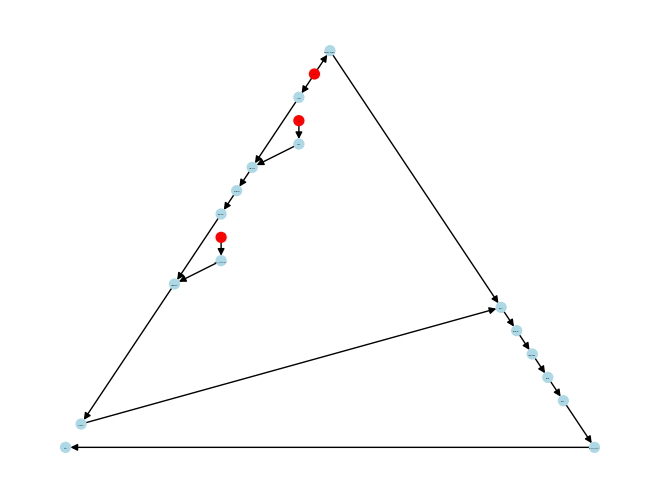

In [10]:
def draw_graph(graph, start_words):
    # pos = nx.kamada_kawai_layout(graph)
    # pos=nx.spring_layout(graph)
    # pos=nx.circular_layout(graph)
    # pos=nx.random_layout(graph)
    # pos=nx.shell_layout(graph)
    # pos=nx.spectral_layout(graph)
    pos=nx.planar_layout(graph)
    # pos=nx.spiral_layout(graph)


    start_node_labels = [get_node_label(word) for word in start_words]
    node_colors = ['red' if node in start_node_labels else 'lightblue' for node in graph.nodes()]

    ##Note: font_size=0 is sometime helpful
    nx.draw(graph, pos, with_labels=True, font_size=0, node_color=node_colors, edge_color='black', node_size=50, width=1)
    plt.show()

# Example usage:
words = ['dog.n.01', 'cat.n.01','fish.n.01']  # Replace with any list of WordNet synset identifiers
# words=random_noun_synset_names

graph = closure_graph(words)
draw_graph(graph, words)




In [11]:
from bokeh.models import GraphRenderer, StaticLayoutProvider, Circle, HoverTool, ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
import bokeh.palettes as bp
Spectral8 = bp.Spectral8

# Assuming 'graph' is your networkx graph
pos = nx.kamada_kawai_layout(graph)
# pos=nx.spring_layout(graph)
# pos=nx.circular_layout(graph)
# pos=nx.random_layout(graph)
# pos=nx.shell_layout(graph)
# pos=nx.spectral_layout(graph)
# pos=nx.planar_layout(graph)
# pos=nx.spiral_layout(graph)


# Convert node labels to integers for Bokeh
label_to_int = {label: i for i, label in enumerate(graph.nodes())}
int_to_label = {i: label for label, i in label_to_int.items()}

# Create a new graph where nodes are integers
int_graph = nx.relabel_nodes(graph, label_to_int)

# Bokeh Graph rendering
plot = figure(title=f"Hypernym closure of {words}", x_range=(-1.2,1.2), y_range=(-1.5,1.5),
              tools="", toolbar_location=None)


graph_renderer = GraphRenderer()

node_indices = list(int_graph.nodes())
colors = [Spectral8[i % len(Spectral8)] for i in range(len(node_indices))]
node_labels = [int_to_label[node] for node in node_indices]

graph_renderer.node_renderer.data_source.add(node_indices, 'index')
graph_renderer.node_renderer.data_source.add(colors, 'color')
graph_renderer.node_renderer.data_source.add(node_labels, 'label')
graph_renderer.node_renderer.glyph = Circle(size=15, fill_color='color')

graph_renderer.edge_renderer.data_source.data = dict(
    start=[label_to_int.get(start, start) for start, end in int_graph.edges],
    end=[label_to_int.get(end, end) for start, end in int_graph.edges]
)

graph_layout = {node: pos[int_to_label[node]] for node in node_indices}
graph_renderer.layout_provider = StaticLayoutProvider(graph_layout=graph_layout)

plot.renderers.append(graph_renderer)

# Update HoverTool to show original labels
hover = HoverTool(tooltips=[("Name", "@label")])  # Changed from "@index" to "@label"
plot.add_tools(hover)

output_notebook()
show(plot)




# Path similarity, distance

In [17]:
# Find synsets for two words
word1 = wn.synset('plane.n.01')
word2 = wn.synset('pig.n.01')
# word1=wn.synset(random_noun_synset_names[0])
# word2=wn.synset(random_noun_synset_names[1])

# Calculate similarities
path_similarity = word1.path_similarity(word2)
wup_similarity = word1.wup_similarity(word2)
lch_similarity = word1.lch_similarity(word2) if word1.pos() == word2.pos() else None
# Lin similarity requires information content, which is not directly available in NLTK without additional resources

# Print results
print(f"the words are {word1} and {word2}")
print("Path Similarity:", path_similarity)
print("Wu-Palmer Similarity:", wup_similarity)
print("Leacock-Chodorow Similarity:", lch_similarity)


the words are Synset('airplane.n.01') and Synset('hog.n.03')
Path Similarity: 0.05
Wu-Palmer Similarity: 0.2962962962962963
Leacock-Chodorow Similarity: 0.6418538861723948


In [21]:
from collections import deque

def shortest_path(synset1, synset2):
    """
    Find the shortest path in the hypernym/hyponym tree between two synsets.
    Returns the path length and the path as a list of synsets.
    """
    # Check if the synsets are the same
    if synset1 == synset2:
        return 0, [synset1]

    # Queue for BFS, initialized with the start synset
    queue = deque([(synset1, [synset1])])

    # Set to keep track of visited synsets to avoid loops
    visited = set([synset1])

    while queue:
        current_synset, path = queue.popleft()

        # Check all the hypernyms and hyponyms of the current synset
        for neighbor in current_synset.hypernyms() + current_synset.hyponyms():
            if neighbor in visited:
                continue

            # Update the path
            new_path = path + [neighbor]

            # Check if the target synset is found
            if neighbor == synset2:
                return len(new_path) - 1, new_path

            # Add to queue and mark as visited
            queue.append((neighbor, new_path))
            visited.add(neighbor)

    # Return None if no path is found
    return None, None

# Example usage
synset1 = wn.synsets('pig')[0]  # First sense of the word
synset2 = wn.synsets('bike')[0]  # First sense of the word
# synset1=wn.synset(random_noun_synset_names[0])
# synset2=wn.synset(random_noun_synset_names[2])

path_length, path = shortest_path(synset1, synset2)
path_length, path
print(path_length)

print(synset1.path_similarity(synset2))
path

18
0.05263157894736842


[Synset('hog.n.03'),
 Synset('swine.n.01'),
 Synset('even-toed_ungulate.n.01'),
 Synset('ungulate.n.01'),
 Synset('placental.n.01'),
 Synset('mammal.n.01'),
 Synset('vertebrate.n.01'),
 Synset('chordate.n.01'),
 Synset('animal.n.01'),
 Synset('organism.n.01'),
 Synset('living_thing.n.01'),
 Synset('whole.n.02'),
 Synset('artifact.n.01'),
 Synset('instrumentality.n.03'),
 Synset('container.n.01'),
 Synset('wheeled_vehicle.n.01'),
 Synset('self-propelled_vehicle.n.01'),
 Synset('motor_vehicle.n.01'),
 Synset('motorcycle.n.01')]

# Hyponym depth

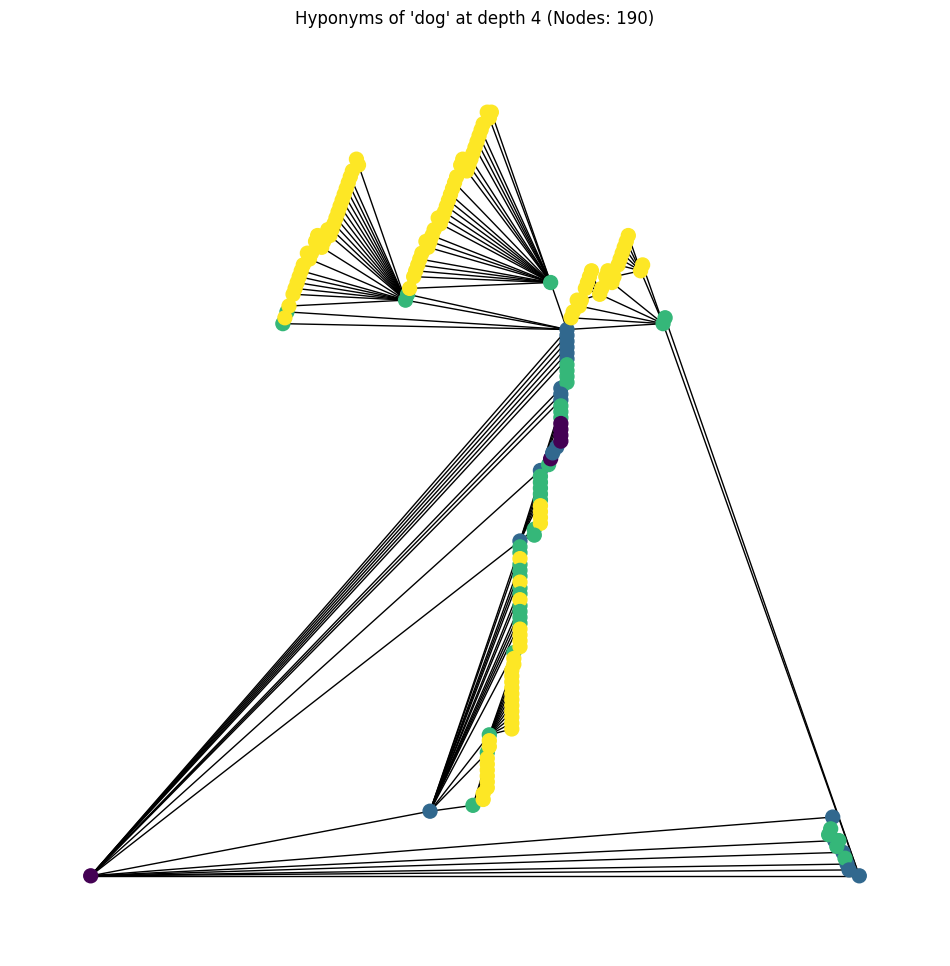

In [57]:
## Function to explore hyponym relationships
def hyponym_relationships(synset, depth, graph, depth_dict, current_depth=0):
    if current_depth < depth:
        synset_name = synset.name().split('.')[0]
        graph.add_node(synset_name)

        # Update the node's depth if it's encountered at a lesser depth
        if synset_name not in depth_dict or current_depth < depth_dict[synset_name]:
            depth_dict[synset_name] = current_depth

        for hyponym in synset.hyponyms():
            hyponym_name = hyponym.name().split('.')[0]
            graph.add_node(hyponym_name)  # Ensure the node is added to the graph
            graph.add_edge(synset_name, hyponym_name)

            # Recursive call with incremented depth
            hyponym_relationships(hyponym, depth, graph, depth_dict, current_depth + 1)

def explore_word_relationships(word, depth):
    G = nx.Graph()
    depth_dict = {}  # Dictionary to store depth of each node

    word_synsets = wn.synsets(word, pos=wn.NOUN)
    for synset in word_synsets:
        synset_name = synset.name().split('.')[0]
        G.add_node(synset_name)
        depth_dict[synset_name] = 0  # Root nodes are at depth 0
        hyponym_relationships(synset, depth, G, depth_dict)

    plt.figure(figsize=(12, 12))

    num_nodes = G.number_of_nodes()
    graph_title = f"Hyponyms of '{word}' at depth {depth} (Nodes: {num_nodes})"
    plt.title(graph_title)

    # Use different layouts
    # pos = nx.kamada_kawai_layout(G)
  # pos=nx.spring_layout(G)
  # pos=nx.circular_layout(G)
  # pos=nx.random_layout(G)
  # pos=nx.shell_layout(G)
  # pos=nx.spectral_layout(G)
    pos=nx.planar_layout(G)
  # pos=nx.spiral_layout(G)



    max_depth = max(depth_dict.values())
    if max_depth == 0:
        # If max_depth is 0, use a default color for all nodes
        colors = ['skyblue' for _ in G.nodes()]
    else:
        # Assign colors based on depth, using a default depth for nodes not in depth_dict
        colors = [(depth_dict.get(node, max_depth) / max_depth) for node in G.nodes()]

    nx.draw(G, pos, node_color=colors, cmap=plt.cm.viridis, with_labels=False, node_size=100, font_size=10)
    plt.show()


dog=wn.synset('dog.n.01')
# Example usage
explore_word_relationships('dog', 4)

In [51]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import GraphRenderer, StaticLayoutProvider, Circle, MultiLine, HoverTool, ColumnDataSource
from bokeh.palettes import Viridis256
import networkx as nx
from nltk.corpus import wordnet as wn
import math

In [67]:
def explore_word_relationships_bokeh(word, depth):
    G = nx.Graph()
    depth_dict = {}

    word_synsets = wn.synsets(word, pos=wn.NOUN)
    for synset in word_synsets:
        synset_name = synset.name().split('.')[0]
        G.add_node(synset_name)
        depth_dict[synset_name] = 0
        hyponym_relationships(synset, depth, G, depth_dict)

    # Create a mapping of node names to integers
    node_indices = {node: i for i, node in enumerate(G.nodes())}
    starting_node_index = node_indices[word_synsets[0].name().split('.')[0]]

    # Inverse mapping for hover tool
    index_to_name = {i: node for node, i in node_indices.items()}

    # Bokeh graph setup
    plot = figure(title=f"Hyponyms of '{word}' at depth {depth}", x_range=(-1.1,1.1), y_range=(-1.1,1.1),
                  tools="", toolbar_location=None)

    graph = GraphRenderer()

    graph.node_renderer.data_source.add(list(node_indices.values()), 'index')
    graph.node_renderer.glyph = Circle(size=15, fill_color='color')

    colors = ['red' if i == starting_node_index else Viridis256[int(math.floor((depth_dict.get(node, max(depth_dict.values())) / max(depth_dict.values())) * 255))] for i, node in enumerate(G.nodes())]
    graph.node_renderer.data_source.add(colors, 'color')

    # Adjust edge data source for Bokeh
    start_indices = [node_indices[node] for node, _ in G.edges()]
    end_indices = [node_indices[node] for _, node in G.edges()]
    graph.edge_renderer.data_source.data = dict(start=start_indices, end=end_indices)

    # Use Kamada-Kawai layout for nodes, using integer indices
    pos = nx.kamada_kawai_layout(G, scale=1, center=(0,0))
    # pos = nx.spring_layout(G, scale=1, center=(0,0))
    layout_pos = {node_indices[node]: (x, y) for node, (x, y) in pos.items()}
    graph.layout_provider = StaticLayoutProvider(graph_layout=layout_pos)



    plot.renderers.append(graph)

    # Add hover tool - show actual node names
    graph.node_renderer.data_source.add([index_to_name[i] for i in node_indices.values()], 'name')
    hover = HoverTool(tooltips=[("Word", "@name")])
    plot.add_tools(hover)

    output_notebook()
    show(plot)




# Example usage
plane=wn.synset('plane.n.01')
explore_word_relationships_bokeh('plane', 2)


In [71]:
# dir(plane)
plane.definition()

'an aircraft that has a fixed wing and is powered by propellers or jets'